In [1]:
#그래프 한글표현 인스톨?

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

In [3]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,가-힣ㄱ-ㅎㅏ-ㅣ0-9]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [4]:
with open('korean-english-park.train.ko', "r") as f:
    raw = f.read().splitlines()
raw = [preprocess_sentence(sentence) for sentence in raw]
print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)
    
with open('korean-english-park.train.en', "r") as f:
    rawen = f.read().splitlines()
rawen = [preprocess_sentence(sentence,True,True) for sentence in rawen]
print("Data Size:", len(rawen))
print("Example:")

for sen in rawen[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데 , 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다 .
>> 경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로 , 그리고 전문적으로 사용되고 있습니다 .
>> 수자원부 당국은 논란이 되고 있고 , 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다 .
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에 , 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다 .
Data Size: 94123
Example:
>> <start> much of personal computing is about can you top this ? <end>
>> <start> amid mounting pressure on north korea to abandon its nuclear weapons program japanese and north korean diplomats have resumed talks on normalizing diplomatic relations . <end>
>> <start> guard robots are used privately and professionally to detect intruders or fire , karlsson said . <end>
>> <start> authorities from the water resources ministry plan to begin construction next year on the controversial and hugely expensive project . <end>
>> <start> researchers also have debated whether we

In [5]:
#병렬데이터 중복 제거
cleaned_corpus = set(zip(raw, rawen))

In [6]:
#데이터 분리
ko_dataset1, en_dataset2 = zip(*cleaned_corpus)

In [7]:
for sen in ko_dataset1[0:100][::20]: print(">>", sen)
for sen in en_dataset2[0:100][::20]: print(">>", sen)

>> ms는 가장 중요한 변화 영역이 사용자 인터페이스라고 밝혔다 .
>> 셔리 주교의 선출은 논쟁의 여지가 많다 .
>> 그는 동료의 말에 의하면 폭발물이 설치된 지점을 지나는 다른 차들에는 아무런 일도 없었지만 그의 차만 폭발했다 고 말했다 .
>> 크레이그 맥스 블랜더 편집국장은 전통적인 레코드 사업을 고수하면 음악산업에서 영향력을 행사할 수 없다 며 컴퓨터 광이나 블로거 , 실리콘 벨리의 인재들이 산업을 선도하고 있다 고 주장했다 .
>> 이라크에서 차량 자살 폭탄 테러로 12명 사망 , 35명 부상
>> <start> one key area that s set to change , says microsoft , is user interface . <end>
>> <start> the bishops voted 95 93 to back ms schori after a number of ballots , ap news agency reported . <end>
>> <start> my colleagues told me all other cars passed where the bomb was planted and only that car when it came into the area the bomb exploded , he said . <end>
>> <start> today s power brokers no longer work in the steel and glass towers of the traditional record business instead , they re tech geeks , bedroom bloggers and silicon valley visionaries . <end>
>> <start> a suicide car bomber killed 12 people and injured 35 people in iraq . <end>


In [8]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer
from konlpy.tag import Mecab
mecab = Mecab()
def tokenize_ko(corpus):
     
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(mecab.morphs(text) for text in corpus)

    tensor = tokenizer.texts_to_sequences(mecab.morphs(text) for text in corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, tokenizer

In [28]:
selected_data = []
max_token_length = 40 #토큰의 길이가 40 이하인 데이터를 선별
for sentence1, sentence2 in cleaned_corpus:
    tokens1 = mecab.morphs(sentence1)
    tokens2 = sentence2.split()
    
    if len(tokens1) <= max_token_length and len(tokens2) <= max_token_length:
        selected_data.append((sentence1, sentence2))
# for sentence1, sentence2 in selected_data:
#     print(sentence1, sentence2)        
# ko_dataset1, en_dataset2 = zip(*selected_data)
ko_dataset1 = [data[0] for data in selected_data]
en_dataset2 = [data[1] for data in selected_data]
for sen in ko_dataset1[0:100][::20]: print(">>", sen)
for sen in en_dataset2[0:100][::20]: print(">>", sen)

>> ms는 가장 중요한 변화 영역이 사용자 인터페이스라고 밝혔다 .
>> 그는 또 올랜도 경찰이 사과를 두 번 깨물고 싶어한다 고 비난했다 .
>> 영국 프리미어리그 epl 아스날의 주장인 윌리암 갈라스가 사타구니 부상으로 앞으로 3주간 경기에 출전할 수 없다고 20일 현지시간 클럽 관계자가 밝혔다 .
>> 이라크에서 차량 자살 폭탄 테러로 12명 사망 , 35명 부상
>> 시아첸은 처음에는 괜찮았지만 점점 배가 고파와 향기로운 냄새가 난다고 생각하며
>> <start> one key area that s set to change , says microsoft , is user interface . <end>
>> <start> and he accused orlando police of wanting a second bite of the apple . <end>
>> <start> arsenal captain william gallas will be sidelined for three weeks with a groin injury , the premier league club said on monday . <end>
>> <start> a suicide car bomber killed 12 people and injured 35 people in iraq . <end>
>> <start> at first there was no feeling , but then i was so hungry i couldn t crawl any more , xianchen told the beijing news . <end>


In [29]:
dec_train, dec_tokenizer = tokenize(en_dataset2)
enc_train, enc_tokenizer = tokenize_ko(ko_dataset1)


In [30]:
print(enc_train.shape)
print(dec_train.shape)

(61052, 40)
(61052, 40)


In [12]:
for sen in enc_train[0:100][::20]: print(">>", sen)
for sen in dec_train[0:100][::20]: print(">>", sen)

>> [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0  2101
     4   146   400    18   482  5985     3   172    86 18714    35    40
     2     1]
>> [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0 14301     7
   187    38  4803    23   123   188    24    18   490     5  1159     7
 29798 29799  1152   498     3 22672 14302 29800 14302     6  1152  2822
   205     8   294 12959    16 

In [13]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn



In [14]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [15]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [31]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 1024)
Decoder Output: (64, 39259)
Decoder Hidden State: (64, 1024)
Attention: (64, 40, 1)


In [17]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)



In [32]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss



In [38]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 1

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm
        break

Epoch  1:   0%|          | 0/954 [00:00<?, ?it/s, Loss 3.9922]


the
.
<start>
<end>
40
tf.Tensor([[3]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor

/tmp/ipykernel_205/1324087137.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_205/1324087137.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


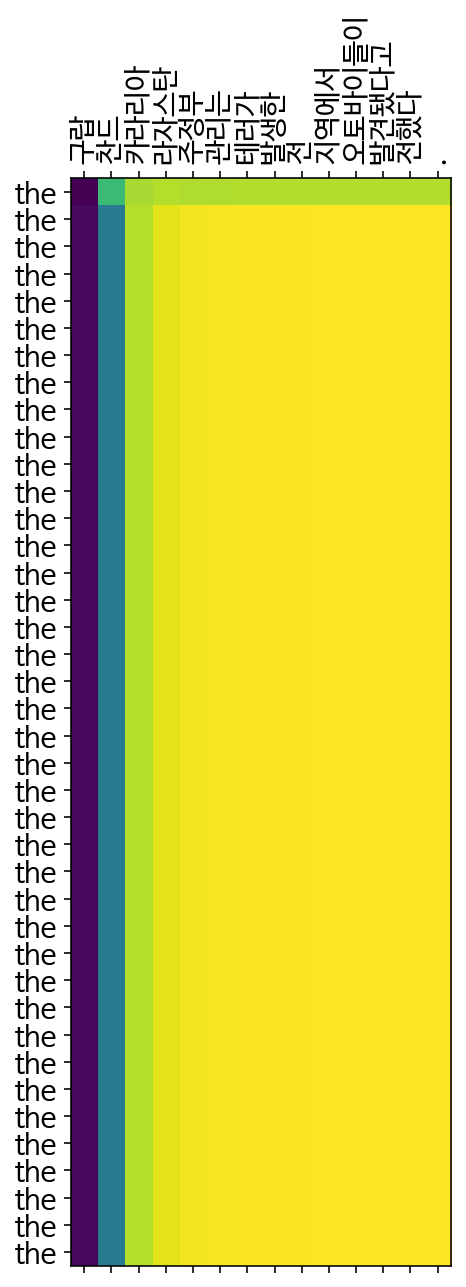

In [39]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([mecab.morphs(sentence)])#형태소분석결과를 인풋으로 넣어준다
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='pre')
    print(enc_train.shape[-1])
    result = ''
#     print(inputs)
    enc_out = encoder(inputs)
#     print(enc_out)
    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        print(dec_input)
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()
#         print(dec_input)
#         print(dec_hidden)
#         print(enc_out)
        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()
#         print(predicted_id)
        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))
# print(mecab.morphs("바보 바보 바보 바보"))
# print(dec_tokenizer.index_word[0])
print(dec_tokenizer.index_word[1])
print(dec_tokenizer.index_word[2])
print(dec_tokenizer.index_word[3])
print(dec_tokenizer.index_word[4])
# print(enc_tokenizer.texts_to_sequences(["바보 바보 바보 바보".split()]))
translate("구랍 찬드 카라리아 라자스탄 주정부 관리는 테러가 발생한 전 지역에서 오토바이들이 발견됐다고 전했다 .", encoder, decoder)